# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import random

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughlt 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **deconvolutional** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but it reverse. A stride in the input layer results in a larger stride in the deconvolutional layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a deconvolutional layer. Deconvolution is often called "transpose convolution" which is what you'll find the TensorFlow API, with [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, deconvolutional layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor).

In [4]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

In [5]:
### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

## Overall approach for computing similarity:
* The **encoded** layer is of shape: (batch_size, 4, 4, 8), i.e. it is a set of 8 filters, each filters being a 4x4 matrix
* To start of with, take only two images (i.e. batch_size = 2). Then we will compare similarity of these images as follows:
 * get encoded.get(0), which gives us the tensor (4, 4, 8) for image-1. Let's call it output-0
 * get encoded.get(1), which gives us the tensor (4, 4, 8) for image-2. Let's call it output-1
 * Now for each output and each filter, flatten the 4x4 tensor into one long vector of length 16. 
 * Now  we have two flattened output sets: flat-1 (8,16) and flat-2(8,16)
 * My inclination to move forward, is to calculate the cosine similarity of each pair of vectors from flat-1 and flat-2. This gives us: 8 x 8 = 64 values of cosine similarity. Then evaluate the average of these cosine similarities which should give us some sense of closeness between image-1 and image-2

* Automate the above process for many images and batches. Can we observe something decent?

In [6]:
unrolled = tf.reshape(encoded, [-1, 16, 8])

### Extract the column vectors from the unrolled tensor above.
- col2_a_n (where n ranges from 0 to 7) represents the eight unrolled vector for the first image
- col2_b_n (where n ranges from 0 to 7) represents the eight unrolled vector for the second image.

The **eight** unrolled vector comes from the eight filters we have in the innermost layers of the convolution network.

In [7]:
col2_a_0 = tf.slice(unrolled,begin=[0,0,0],size=[1,16,1])
col2_b_0 = tf.slice(unrolled,begin=[1,0,0],size=[1,16,1])

col2_a_1 = tf.slice(unrolled,begin=[0,0,1],size=[1,16,1])
col2_b_1 = tf.slice(unrolled,begin=[1,0,1],size=[1,16,1])

col2_a_2 = tf.slice(unrolled,begin=[0,0,2],size=[1,16,1])
col2_b_2 = tf.slice(unrolled,begin=[1,0,2],size=[1,16,1])

col2_a_3 = tf.slice(unrolled,begin=[0,0,3],size=[1,16,1])
col2_b_3 = tf.slice(unrolled,begin=[1,0,3],size=[1,16,1])

col2_a_4 = tf.slice(unrolled,begin=[0,0,4],size=[1,16,1])
col2_b_4 = tf.slice(unrolled,begin=[1,0,4],size=[1,16,1])

col2_a_5 = tf.slice(unrolled,begin=[0,0,5],size=[1,16,1])
col2_b_5 = tf.slice(unrolled,begin=[1,0,5],size=[1,16,1])

col2_a_6 = tf.slice(unrolled,begin=[0,0,6],size=[1,16,1])
col2_b_6 = tf.slice(unrolled,begin=[1,0,6],size=[1,16,1])

col2_a_7 = tf.slice(unrolled,begin=[0,0,7],size=[1,16,1])
col2_b_7 = tf.slice(unrolled,begin=[1,0,7],size=[1,16,1])

In [8]:
def compute_magnitude(vec):
    squares = tf.square(vec)
    sum = tf.reduce_sum(squares)
    sqrt = tf.sqrt(sum)
    return sqrt

In [9]:
def compute_dot_prod(vec1, vec2):
    # vec1, vec2 are tensors obtained
    # by taking tf.slices
    foo = tf.reshape(vec1,[-1])
    bar = tf.reshape(vec2,[-1])
    
    foo_L2_norm = compute_magnitude(foo)
    bar_L2_norm = compute_magnitude(bar)
    
    val = tf.reduce_sum(tf.multiply(foo,bar))
    
    cos_theta = tf.divide(val, foo_L2_norm * bar_L2_norm)
    return cos_theta

In [10]:
import math

In [11]:
def get_avg(val0, val1, val2, val3, val4, val5, val6, val7):
    list = [val0, val1, val2, val3, val4, val5, val6, val7]

    sum = 0.
    counter = 0
    
    for item in list:
        if(not math.isnan(item)):
            sum = sum + item
            counter +=1
        else:
            pass
            
    if (counter>0):
        return sum/counter
    else:
        return 0.

### Evaluate the differences metrics. 
This essentially evaluates the cosine similarity between two matrices, i.e given vectors: $v_1$ and $v_2$
$$diff \equiv cos(\theta) = \frac{v_1.v_2}{||v_1||.||v_2||}$$

In [12]:
diff_0 = compute_dot_prod(col2_a_0, col2_b_0)
diff_1 = compute_dot_prod(col2_a_1, col2_b_1)
diff_2 = compute_dot_prod(col2_a_2, col2_b_2)
diff_3 = compute_dot_prod(col2_a_3, col2_b_3)
diff_4 = compute_dot_prod(col2_a_4, col2_b_4)
diff_5 = compute_dot_prod(col2_a_5, col2_b_5)
diff_6 = compute_dot_prod(col2_a_6, col2_b_6)
diff_7 = compute_dot_prod(col2_a_7, col2_b_7)

### Training

In [15]:
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [44]:
start_epoch=30
end_epoch=start_epoch+10

### Load data from checkpoint

In [24]:
new_saver = tf.train.import_meta_graph('mode_saved-35.meta')

In [31]:
new_saver.restore(sess,'./mode_saved-35')

In [45]:
batch_size = 256
num_iter_per_epochs = mnist.train.num_examples//batch_size

for e in range(start_epoch,end_epoch):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
    print("Epoch: {}/{}...".format(e+1, end_epoch),
          "Training loss: {:.4f}".format(batch_cost))
    if(e%5==0):
        saver.save(sess, "mode_saved", global_step=e)

Epoch: 31/40... Training loss: 0.1047
Epoch: 32/40... Training loss: 0.1042
Epoch: 33/40... Training loss: 0.1021
Epoch: 34/40... Training loss: 0.1015
Epoch: 35/40... Training loss: 0.1002
Epoch: 36/40... Training loss: 0.0981
Epoch: 37/40... Training loss: 0.1006
Epoch: 38/40... Training loss: 0.1024
Epoch: 39/40... Training loss: 0.0989
Epoch: 40/40... Training loss: 0.1032


### Plot the images to make sure we have a reasonably good model

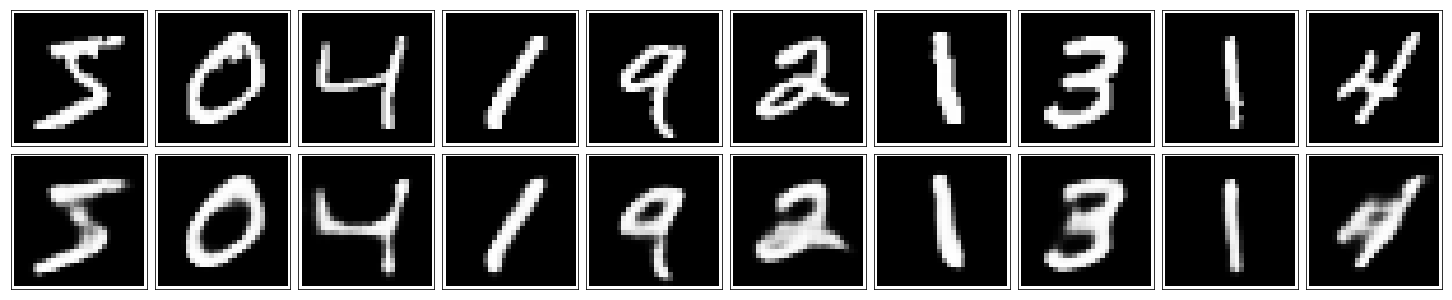

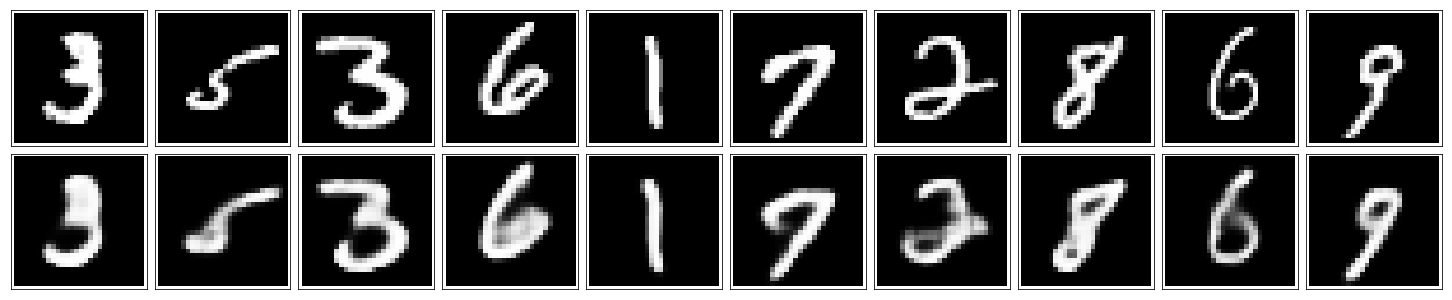

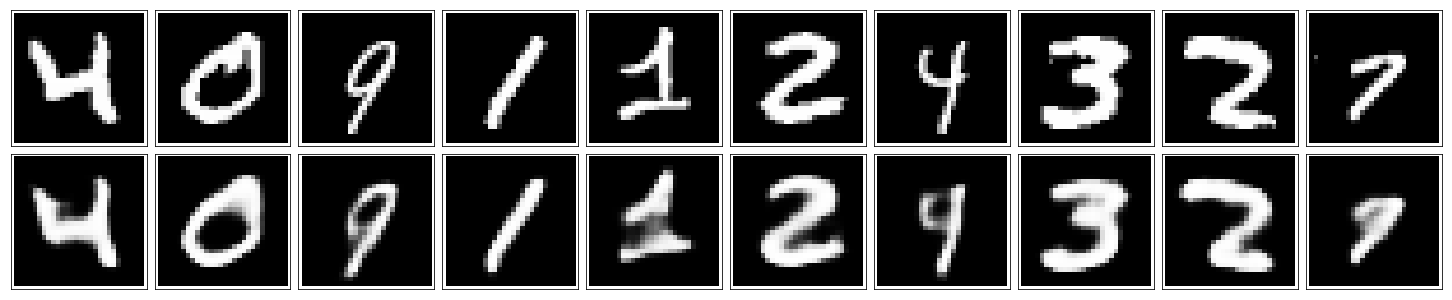

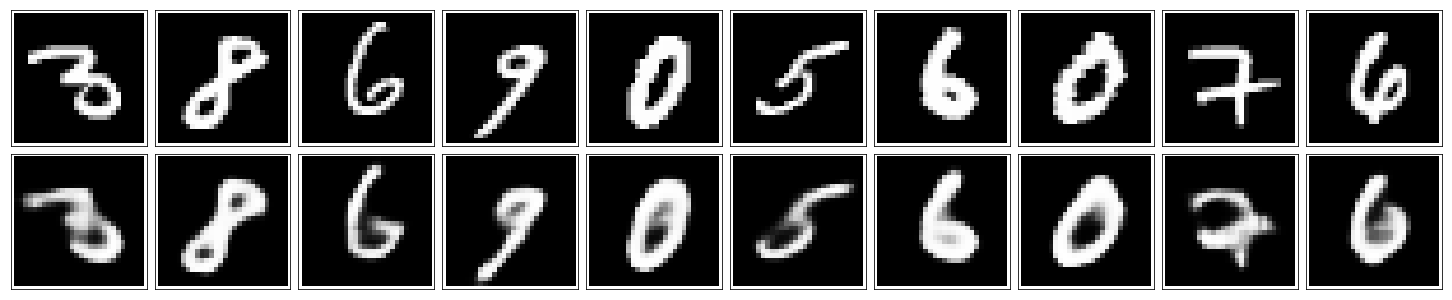

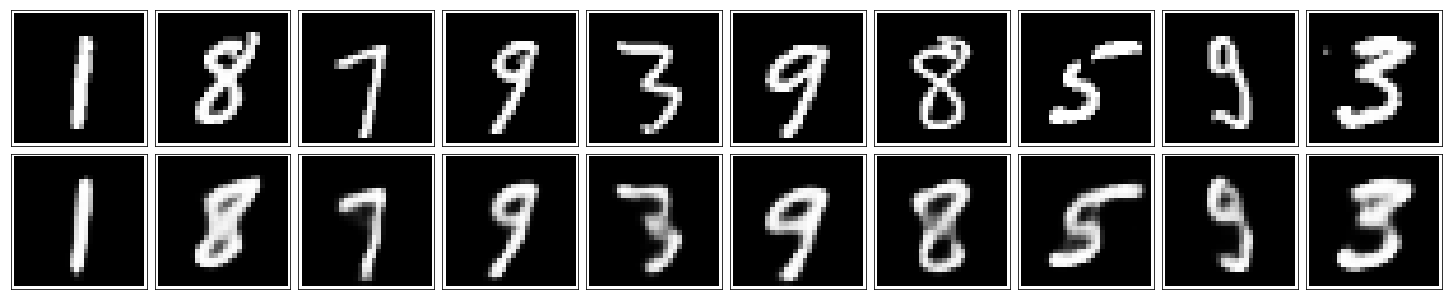

In [32]:
for i in range(5):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    in_imgs = mnist.train.images[10*i:10*(i+1)]
    reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

    for images, row in zip([in_imgs, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


    fig.tight_layout(pad=0.1)

### Computing similarities and making observations
Now that the model is trained to our heart's content, we need to calculate the similarities we defined above. First of all, get a handle to all the labels in **mnist.train.images** that correspond to each of the digits (0 to 9)

In [33]:
num_images = len(mnist.train.images)

labels = {}
for digit in range(10):
    labels[digit]=[i for i in range(num_images) if mnist.train.labels[i]==digit]

#### The following method will pick N different images of the first and second numbers, then compute the averages of the similarities

In [43]:
def compute_similarity(l_first, l_second):
    '''
    l_first: first number to compare
    l_second: second number to compare
    '''
    N = 1000
    temp = []
    for ij in range(N):
        first = random.choice(labels[l_first])   # random label that point to the first number
        second = random.choice(labels[l_second]) # random label that point to the second number

        in_imgs = np.concatenate((mnist.train.images[first:first+1], mnist.train.images[second:second+1]),axis=0)
        in_labels = np.concatenate((mnist.train.labels[first:first+1], mnist.train.labels[second:second+1]),axis=0)

        # compute similarity values
        val0, val1, val2, val3, val4, val5, val6, val7= \
            sess.run([diff_0, diff_1, diff_2, diff_3, diff_4, diff_5, diff_6, diff_7], feed_dict={inputs_ : in_imgs.reshape(2,28,28,1)})

        avg = get_avg(val0, val1, val2, val3, val4, val5, val6, val7)
        temp.append((in_labels[0], in_labels[1], val0, val1, val2, val3, val4, val5, val6, val7, avg))

    foobar = sorted(temp, key=lambda x: x[10])
    avg = 0.
    for item in foobar:
        avg = avg+item[10]

    avg = avg/len(foobar)
    print("num_1{:2d}, num_2{:2d}, avg similarity:{:7.4f} ".format(l_first, l_second, avg))
    return avg


### Finally, compute the similarities

In [ ]:
diff_matrix = np.zeros((10,10))
cnt = 0
for i in range(10):
    for j in range(i,10):
        cnt +=1
        avg_diff = compute_similarity(i,j)
        diff_matrix[i,j] = avg_diff
        print("done: ",cnt," of 55")

### Print in a nice tabular form

In [71]:
def table_print(diff_matrix):
    print("{:7s}|{:7d}|{:7d}|{:7d}|{:7d}|{:7d}|{:7d}|{:7d}|{:7d}|{:7d}|{:7d}".format(' ',0,1,2,3,4,5,6,7,8,9))
    print("     ----------------------------------------------------------------------------------")
    for i in range(10):
            print("{:7d}|{:7.4f}|{:7.4f}|{:7.4f}|{:7.4f}|{:7.4f}|{:7.4f}|{:7.4f}|{:7.4f}|{:7.4f}|{:7.4f}".\
                  format(i,diff_matrix[i,0],diff_matrix[i,1],diff_matrix[i,2],diff_matrix[i,3],diff_matrix[i,4],\
                        diff_matrix[i,5],diff_matrix[i,6],diff_matrix[i,7],diff_matrix[i,8],diff_matrix[i,9]))
            print("     ----------------------------------------------------------------------------------")

In [70]:
diff_matrix_copy = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        diff_matrix_copy[i,j] = diff_matrix[i,j]

In [72]:
table_print(diff_matrix_copy)

       |      0|      1|      2|      3|      4|      5|      6|      7|      8|      9
     ----------------------------------------------------------------------------------
      0| 0.9465| 0.8620| 0.8950| 0.9058| 0.8850| 0.9121| 0.9159| 0.8745| 0.9176| 0.8790
     ----------------------------------------------------------------------------------
      1| 0.0000| 0.9446| 0.8761| 0.8854| 0.8811| 0.8884| 0.8992| 0.8921| 0.8991| 0.8934
     ----------------------------------------------------------------------------------
      2| 0.0000| 0.0000| 0.9050| 0.8946| 0.8769| 0.8896| 0.9085| 0.8684| 0.8983| 0.8747
     ----------------------------------------------------------------------------------
      3| 0.0000| 0.0000| 0.0000| 0.9250| 0.8804| 0.9095| 0.9060| 0.8850| 0.9172| 0.8847
     ----------------------------------------------------------------------------------
      4| 0.0000| 0.0000| 0.0000| 0.0000| 0.9164| 0.8895| 0.9133| 0.8955| 0.8962| 0.9089
     ---------------------------

In [73]:
for i in range(10):
    for j in range(i,10):
        diff_matrix_copy[j,i] = diff_matrix_copy[i,j]

In [74]:
table_print(diff_matrix_copy)

       |      0|      1|      2|      3|      4|      5|      6|      7|      8|      9
     ----------------------------------------------------------------------------------
      0| 0.9465| 0.8620| 0.8950| 0.9058| 0.8850| 0.9121| 0.9159| 0.8745| 0.9176| 0.8790
     ----------------------------------------------------------------------------------
      1| 0.8620| 0.9446| 0.8761| 0.8854| 0.8811| 0.8884| 0.8992| 0.8921| 0.8991| 0.8934
     ----------------------------------------------------------------------------------
      2| 0.8950| 0.8761| 0.9050| 0.8946| 0.8769| 0.8896| 0.9085| 0.8684| 0.8983| 0.8747
     ----------------------------------------------------------------------------------
      3| 0.9058| 0.8854| 0.8946| 0.9250| 0.8804| 0.9095| 0.9060| 0.8850| 0.9172| 0.8847
     ----------------------------------------------------------------------------------
      4| 0.8850| 0.8811| 0.8769| 0.8804| 0.9164| 0.8895| 0.9133| 0.8955| 0.8962| 0.9089
     ---------------------------

In [77]:
for i in range(10):
    row = diff_matrix_copy[i,:]
    print("i: ",i," order (least to most): ",np.argsort(row))

i:  0  order (least to most):  [1 7 9 4 2 3 5 6 8 0]
i:  1  order (least to most):  [0 2 4 3 5 7 9 8 6 1]
i:  2  order (least to most):  [7 9 1 4 5 3 0 8 2 6]
i:  3  order (least to most):  [4 9 7 1 2 0 6 5 8 3]
i:  4  order (least to most):  [2 3 1 0 5 7 8 9 6 4]
i:  5  order (least to most):  [7 9 1 4 2 6 3 0 5 8]
i:  6  order (least to most):  [7 1 9 3 5 2 4 8 0 6]
i:  7  order (least to most):  [2 0 5 3 6 1 4 8 9 7]
i:  8  order (least to most):  [4 7 2 9 1 6 3 0 5 8]
i:  9  order (least to most):  [2 0 3 5 1 8 7 6 4 9]
